# FIN 514 - PS3_Q1 Python Codes
**Spring 2022**


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [6]:
N = 100
S0 = 227.29
K = 193.20
sigma = 0.3573
r = 0.048
T = 1
D = 0.0219
ND = 4
TD = np.zeros([ND]) #creates an array with 4 entries
TD = [1/12, 4/12, 7/12, 10/12] #corresponding to jan, apr, jul, oct
Tac = [3/12, 6/12, 9/12] # corresponding to 1/4, 1/2 &3/4

## Stock value tree

In [4]:
def Stock_tree(N, S0, sigma, r, T, D, TD):
    
    stock_value = np.zeros([N+1, N+1])    
    
    delta = T / N
    u = np.exp(r*delta + sigma * (delta)**0.5)
    d = np.exp(r*delta - sigma * (delta)**0.5)
    print("u = ", u, "d=", d)

    # FIRST LET'S BUILD A STOCK PRICE TREE WITH DIVIDENDS  
    # Let's have dividends at grid points rather than times
    jD1 = [i/delta for i in TD]
    jD = [np.ceil(i) for i in jD1]
    print(jD)
    
    stock_value[0,0] = S0
    for j in range (1,N+1):
        stock_value[j, 0] = stock_value[j-1, 0]*d 
        for i in range(1, j+1):    
            stock_value[j, i] = stock_value[j-1, i-1]*u      

    # This adjusts all stock prices for that j by the size of the dividend    
        if j in jD: stock_value[j, :] *= (1-D)
    print(stock_value[3,0], stock_value[50,0], stock_value[50,50], stock_value[100,0], stock_value[100,100])        
    return stock_value

In [5]:
stock = Stock_tree(N, S0, sigma, r, T, D, TD)
stock

u =  1.0368735670785485 d= 0.9653640450761569
[9.0, 34.0, 59.0, 84.0]
204.48134220721911 37.31666485389899 1329.3428558939984 6.126681665793567 7774.879794607821


array([[2.27290000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.19417594e+02, 2.35670993e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.11817856e+02, 2.27508303e+02, 2.44361023e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.57420249e+00, 7.06118777e+00, 7.58424657e+00, ...,
        7.23172790e+03, 0.00000000e+00, 0.00000000e+00],
       [6.34649871e+00, 6.81661679e+00, 7.32155895e+00, ...,
        6.98125010e+03, 7.49838750e+03, 0.00000000e+00],
       [6.12668167e+00, 6.58051675e+00, 7.06796976e+00, ...,
        6.73944783e+03, 7.23867369e+03, 7.77487979e+03]])

In [7]:
#Coupon 
Cpn = 0.1185
NC = 12
TC = list(np.linspace(1/NC, 1, NC))
Face = 1000

In [6]:

def ac_option(S0, Face, K, T, r, sigma, N, stock_value, Cpn, NC, TC, Tac):
    
     # LIST TO SAVE RESULTS
    convertible_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([N+1, N+1])
    
    Deltat = T / N
    u = np.exp(r*Deltat+sigma * (Deltat)**0.5)
    d = np.exp(r*Deltat-sigma * (Deltat)**0.5)
    q = (np.exp(r * Deltat) - d) / (u - d)

    #First, let's calculate the coupon dates and accrued interest

    #jC1 are the exact values of j where the coupons are paid
    #jC are the values of j where we first factor in the coupons - 
    #where int will give us the j immediately before or on the coupon/call date
    jc1 = [j/Deltat for j in TC]
    jc = [int(j) for j in jc1]
    #jcall = int(tcall/Deltat)
    #print("call period starts", jcall)
    
    jac1 = [j/Deltat for j in Tac]
    jac = [int(j) for j in jac1]

    
    j = N
    
    for i in range(0, j+1):
        if stock_value[j,i] >= K:
            option_value[j,i] = Face*(1+Cpn/NC)
        else:
            option_value[j,i] = Face/K*stock_value[j,i] + Face*(Cpn/NC)
    
                             
    for j in range(N-1, -1, -1):
        
        if j in jac: 
            next_ac_date = Tac[jac.index(j)]
            prev_ac_date = Tac[jac.index(j)-1] 
            print("auto call date",j,jac.index(j),next_ac_date,prev_ac_date) 
        
            ndt = Tac[jac.index(j)]-Deltat*j
       
        
        for i in range(0, j+1):
            cont = np.exp(-r * Deltat) * (q * option_value[j + 1, i + 1] + (1-q) * option_value[j + 1, i])
            if j in jc:
                cont = cont + Face*Cpn/NC*np.exp(-r*(TC[jc.index(j)]-Deltat*j))

            option_value[j, i] = cont
            

            if j in jac:
                if stock_value[j,i]>= S0:
                    option_value[j, i] = Face*(1+Cpn/NC)
                    
                elif stock_value[j,i] * np.exp(r*ndt + sigma * (ndt)**0.5) >= S0:
                    option_value[j, i] = Face*(1+Cpn/NC) * np.exp(-r*ndt)
                    print(option_value[j,i])


    output = {'num_steps': N, 'Value': option_value[0,0]}
    convertible_result.append(output)

    return convertible_result




In [9]:
value = ac_option(S0, Face, K, T, r, sigma, N, stock, Cpn, NC, TC, Tac)
value

auto call date 75 2 0.75 0.5
auto call date 50 1 0.5 0.25
auto call date 25 0 0.25 0.75


[{'num_steps': 100, 'Value': 972.9871806870709}]

# Problem 2

In [10]:
# ENTER INPUT FOR: S0 = Original Stock Price
S0 = 100
# ENTER INPUT FOR: K = Excercise Price of Call Option
K = 105
# ENTER INPUT FOR: sigma = Annualized (Future) Volatility of Stock Price Returns
sigma = 0.3
# ENTER INPUT FOR: r = Annualized Continously Compounded Risk-free Rate
r = 0.04
# ENTER INPUT FOR: T = Time Length of Option in which to Exercise (In Years)
T = 0.5
# ENTER INPUT FOR: D = proportional dividend
D = 0.0
# ENTER INPUT FOR: ND = number of dividends and TD = array of dividend dates
ND = 0
TD = np.zeros([ND]) #creates an array with 4 entries

# •	Cox, Ross and Rubinstein

In [11]:
def crr_European(S0, K, T, r, sigma, N, D, TD):
    
    # LIST TO SAVE RESULTS
    Euro_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    stock_value = np.zeros ([N+1, N+1])
    option_value = np.zeros([N+1, N+1])
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    
    Deltat = T / N
    u = np.exp(sigma*(Deltat)**0.5)
    d = np.exp(-sigma*(Deltat)**0.5)
    q = (np.exp(r * Deltat) - d) / (u - d)
    #print("u: ", u, "d: ", d)
    
    ######################################################################################################################
    
    #STOCK TREE
    
    jD1 = [i/Deltat for i in TD]
    jD = [np.ceil(i) for i in jD1]
    
    
    stock_value[0,0] = S0
    for j in range (1,N+1):
        stock_value[j, 0] = stock_value[j-1, 0]*d 
        for i in range(1, j+1):    
            stock_value[j, i] = stock_value[j-1, i-1]*u      

    # This adjusts all stock prices for that j by the size of the dividend    
        if j in jD: stock_value[j, :] *= (1-D)
    #######################################################################################################################        
        
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    j = N 
    for i in range(0, j+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
 
        option_value[j, i] = np.maximum(K - stock_value[j, i], 0)
    
    # Now, lets calculate the option value at each position (i) within the binomial tree at each previous step number (j) until time zero
    for j in range(N-1, -1, -1):

    # Then, create a FOR iteration on the position number (i), from the top position all the way down to the bottom position of 0 (all down jumps)
        for i in range(j, -1, -1):
            
    # Now, calculation the continuation value of the option at that specific position and step number           
            cv = np.exp(-r * Deltat) * (q*option_value[j+1,i+1] + (1-q)* option_value[j+1,i])
            option_value[j, i] = cv
    # RELAY OUTPUTS TO DICTIONARY
    output = option_value[0,0]
    Euro_result.append(output)
    

    return Euro_result, option_value


# •	Rendleman and Bartter

In [12]:
def rb_European(S0, K, T, r, sigma, N, D, TD):
    
    # LIST TO SAVE RESULTS
    Euro_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    stock_value = np.zeros ([N+1, N+1])
    option_value = np.zeros([N+1, N+1])
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    
    Deltat = T / N
    u = np.exp((r-D-0.5*sigma**2)*Deltat + sigma*(Deltat)**0.5)
    d = np.exp((r-D-0.5*sigma**2)*Deltat - sigma*(Deltat)**0.5)
    q = (np.exp(r * Deltat) - d) / (u - d)
    #print("u: ", u, "d: ", d)
    
    ######################################################################################################################
    
    #STOCK TREE
    
    jD1 = [i/Deltat for i in TD]
    jD = [np.ceil(i) for i in jD1]
    
    
    stock_value[0,0] = S0
    for j in range (1,N+1):
        stock_value[j, 0] = stock_value[j-1, 0]*d 
        for i in range(1, j+1):    
            stock_value[j, i] = stock_value[j-1, i-1]*u      

    # This adjusts all stock prices for that j by the size of the dividend    
        if j in jD: stock_value[j, :] *= (1-D)
    #######################################################################################################################        
        
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    j = N 
    for i in range(0, j+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
 
        option_value[j, i] = np.maximum(K - stock_value[j, i], 0)
    
    # Now, lets calculate the option value at each position (i) within the binomial tree at each previous step number (j) until time zero
    for j in range(N-1, -1, -1):

    # Then, create a FOR iteration on the position number (i), from the top position all the way down to the bottom position of 0 (all down jumps)
        for i in range(j, -1, -1):
            
    # Now, calculation the continuation value of the option at that specific position and step number           
            cv = np.exp(-r * Deltat) * (q*option_value[j+1,i+1] + (1-q)* option_value[j+1,i])
            option_value[j, i] = cv
    # RELAY OUTPUTS TO DICTIONARY
    output = option_value[0,0]
    Euro_result.append(output)
    

    return Euro_result, option_value


# •	Leisen and Reimer

In [13]:
def lr_European(S0, K, T, r, sigma, N, D, TD):
    
    # LIST TO SAVE RESULTS
    Euro_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    stock_value = np.zeros ([N+1, N+1])
    option_value = np.zeros([N+1, N+1])
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    
    Deltat = T / N
    
    def hf(x,N):
        return 0.5 + np.sign(x) * np.sqrt(0.25 - (0.25 * np.exp(-(x/(N+1/3))**2 * (N + 1/6))))

    
    d1 = (np.log(S0/K) + (r-D+0.5*sigma**2)*Deltat)/(sigma*Deltat**0.5)
    d2 = (np.log(S0/K) + (r-D-0.5*sigma**2)*Deltat)/(sigma*Deltat**0.5)
    
    u = np.exp((r-D)*Deltat) * hf(d1,N)/hf(d2,N)
               
               
    d = (np.exp((r-D)*Deltat) - hf(d2,N)*u)/(1-hf(d2,N))
    

         
    q = (np.exp(r * Deltat) - d) / (u - d)
    #print("u: ", u, "d: ", d)
    
    ######################################################################################################################
    
    #STOCK TREE
    
    jD1 = [i/Deltat for i in TD]
    jD = [np.ceil(i) for i in jD1]
    #print("Dividend points", jD)
    
    stock_value[0,0] = S0
    for j in range (1,N+1):
        stock_value[j, 0] = stock_value[j-1, 0]*d 
        for i in range(1, j+1):    
            stock_value[j, i] = stock_value[j-1, i-1]*u      

    # This adjusts all stock prices for that j by the size of the dividend    
        if j in jD: stock_value[j, :] *= (1-D)
    #######################################################################################################################        
        
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    j = N 
    for i in range(0, j+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
 
        option_value[j, i] = np.maximum(K - stock_value[j, i], 0)
    
    # Now, lets calculate the option value at each position (i) within the binomial tree at each previous step number (j) until time zero
    for j in range(N-1, -1, -1):

    # Then, create a FOR iteration on the position number (i), from the top position all the way down to the bottom position of 0 (all down jumps)
        for i in range(j, -1, -1):
            
    # Now, calculation the continuation value of the option at that specific position and step number           
            cv = np.exp(-r * Deltat) * (q*option_value[j+1,i+1] + (1-q)* option_value[j+1,i])
            option_value[j, i] = cv
    # RELAY OUTPUTS TO DICTIONARY
    output = option_value[0,0]
    Euro_result.append(output)
    #print(Euro_result)

    return Euro_result, option_value


# Performance

In [14]:
y = 1
crr_arr = np.zeros(y)
rb_arr = np.zeros(y)
lr_arr = np.zeros(y)
x = 150

for i in range(x, x+1):
    
    crr_arr[i-x] = crr_European(S0, K, T, r, sigma, i, D, TD)[0][0]
    rb_arr[i-x] = rb_European(S0, K, T, r, sigma, i, D, TD)[0][0]
    lr_arr[i-x] = lr_European(S0, K, T, r, sigma, i, D, TD)[0][0]
    
print("crr_arr:", "\n", crr_arr,"\n", "\n"
      "rb_arr: ","\n", rb_arr, "\n", "\n"
      "lr_arr: ", "\n", lr_arr)


crr_arr: 
 [10.12180064] 
 
rb_arr:  
 [10.12263718] 
 
lr_arr:  
 [2.95496845]


In [15]:
def bsf(O, S, K, r, sigma, q, T, disFac):
    
    O = str(O)
    
    d1 = (np.log(S/K) + (r - q + (0.5 * sigma**2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S/K) + (r - q - (0.5 * sigma**2)) * T) / (sigma * np.sqrt(T))
    
    if "Call" in O:
        result = disFac * (S * np.exp((r - q)*T) * ss.norm.cdf(d1, 0,1) - K * ss.norm.cdf(d2, 0, 1))
    elif "Put" in O:
        result = disFac * (K * ss.norm.cdf(-d2, 0, 1) - S * np.exp((r - q)*T) * ss.norm.cdf(-d1, 0,1))
    elif "Dp" in O:
        result = disFac * (ss.norm.cdf(-d2, 0, 1))
    else:
        result = disFac * (-ss.norm.cdf(d2, 0, 1))
    
        
    return result

In [16]:
import scipy.stats as ss

In [21]:
disFac = np.exp(-r*T)

bsm = bsf("Put", S0, K, r, sigma, 0, T, disFac)
bsm

10.10930334495747

In [22]:
crr_arr = np.zeros(951)
rb_arr = np.zeros(951)
lr_arr = np.zeros(951)
x = 50

for i in range(x, 1001):
    
    crr_arr[i-x] = crr_European(S0, K, T, r, sigma, i, D, TD)[0][0] - bsm
    rb_arr[i-x] = rb_European(S0, K, T, r, sigma, i, D, TD)[0][0] - bsm
    lr_arr[i-x] = lr_European(S0, K, T, r, sigma, i, D, TD)[0][0] - bsm
    
#print("crr_arr:", "\n", crr_arr,"\n", "\n",      "rb_arr: ","\n", rb_arr, "\n", "\n",      "lr_arr: ", "\n", lr_arr)

In [31]:
df = pd.DataFrame({"N": np.arange(50,1001), "CRR": crr_arr, "R&B": rb_arr, "L&R": lr_arr})
df

,N,CRR,R&B,L&R
0,50,0.007624,-0.002123,-6.919757
1,51,0.028756,0.032954,-6.927965
2,52,0.003946,-0.006070,-6.933158
3,53,0.029440,0.033117,-6.943487
4,54,0.000443,-0.009828,-6.946154
...,...,...,...,...
946,996,0.001747,0.000330,-7.188441
947,997,-0.000287,0.001441,-7.188441
948,998,0.001728,0.000288,-7.188441
949,999,-0.000241,0.001462,-7.188441


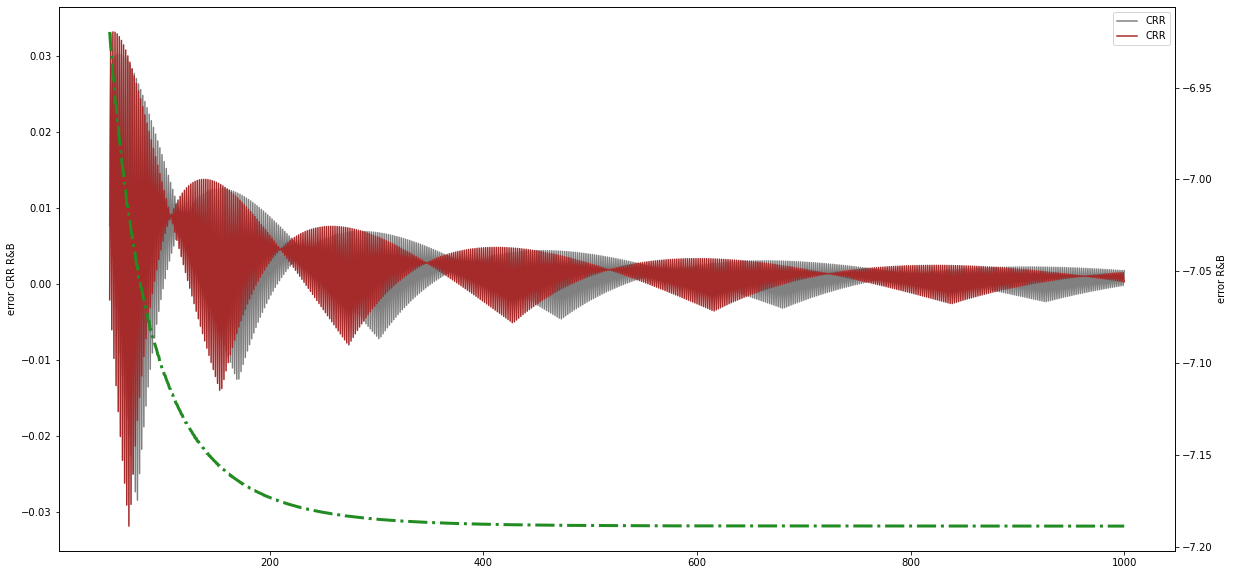

In [32]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(df['N'], df["CRR"],color="gray",linestyle="-",label="CRR")
ax1.plot(df['N'], df["R&B"],color="brown",linestyle="-",label="CRR")
ax1.set_ylabel("error CRR R&B")
ax1.legend();



ax2 = ax1.twinx()
ax2.plot(df['N'], df["L&R"], color ="forestgreen", linestyle = "-.", label ="L&R", linewidth =3)
ax2.set_ylabel("error R&B");
